# Natural Language Processing - Knowledge Graph example

###### Links: [Dataset (Wikipedia page: History of Rome)](https://en.wikipedia.org/wiki/History_of_Rome)  |  [Article (TowardsDataScience)]()

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd  #1.1.5

## for plotting
import matplotlib.pyplot as plt  #3.3.2
import seaborn as sns  #0.11.1

## for text
import wikipediaapi  #0.5.8
import nltk  #3.8.1
import re   
import contractions  #0.1.73

## for nlp
import spacy  #3.5.0
from spacy import displacy

## for graph
import networkx as nx  #3.0
import plotly.graph_objs as go  #5.1.0

## for timeline
import dateparser #1.1.7

###### Import data

In [3]:
topic = "Russo-Ukrainian War"

wiki = wikipediaapi.Wikipedia('en')
page = wiki.page(topic)
txt = page.text[:page.text.find("See also")]
txt[0:500] + " ..."

"The Russo-Ukrainian War is an ongoing international conflict between Russia, alongside Russian-backed separatists, and Ukraine, which began in February 2014. Following Ukraine's Revolution of Dignity, Russia annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas war. The first eight years of conflict also included naval incidents, cyberwarfare, and heightened political tensions. In February 2022, Russia launched a full-scale invasion of Uk ..."

###### Text cleaning

In [4]:
'''
Creates a list of stopwords.
:parameter
    :param lst_langs: list - ["english", "italian"]
    :param lst_add_words: list - list of new stopwords to add
    :param lst_keep_words: list - list words to keep (exclude from stopwords)
:return
    stop_words: list of stop words
'''      
def create_stopwords(lst_langs=["english"], lst_add_words=[], lst_keep_words=[]):
    lst_stopwords = set()
    for lang in lst_langs:
        lst_stopwords = lst_stopwords.union( set(nltk.corpus.stopwords.words(lang)) )
    lst_stopwords = lst_stopwords.union(lst_add_words)
    lst_stopwords = list(set(lst_stopwords) - set(lst_keep_words))
    return sorted(list(set(lst_stopwords)))

In [5]:
lst_stopwords = create_stopwords(lst_add_words=[], lst_keep_words=[])
print(lst_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [6]:
'''
Preprocess a string.
:parameter
    :param txt: string - name of column containing text
    :param dic_regex: dict - regex to replace
    :param punkt: bool - if True removes punctuations and characters
    :param lower: bool - if True convert lowercase
    :param slang: bool - if True fix slang into normal words
    :param lst_stopwords: list - list of stopwords to remove
    :param stemm: bool - whether stemming is to be applied
    :param lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(txt, dic_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, 
                          stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if dic_regex is not None: 
        for k,v in dic_regex.items():
            txt = re.sub(k, v, txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt

In [7]:
#txt = utils_preprocess_text(txt, dic_regex={"-":" "}, punkt=True, lower=False, slang=False, 
#                            lst_stopwords=lst_stopwords, stemm=False, lemm=False)

In [8]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param txt: text
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(txt, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(txt)
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

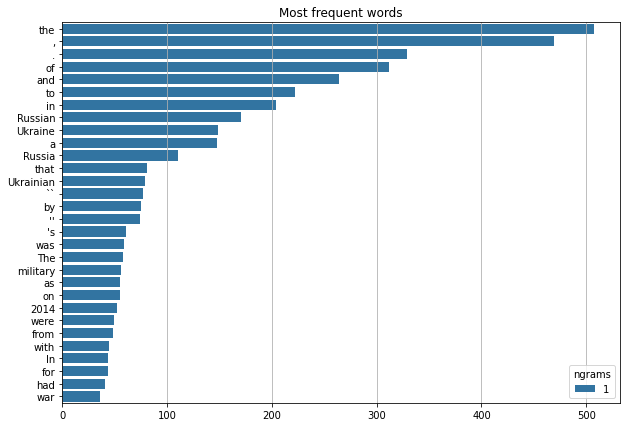

In [9]:
# Find most common words in text
_ = word_freq(txt, ngrams=[1], top=30, figsize=(10,7))

### 1 - NLP

###### Model

In [10]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

###### Sentence Segmentation

In [19]:
lst_docs = [sent for sent in doc.sents]
print("sentences:", len(lst_docs))

i = 1 #67
lst_docs[i]

sentences: 367


Following Ukraine's Revolution of Dignity, Russia annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas war.

In [258]:
for v,m in enumerate(lst_docs):
    print(m, "\n----", v)

The Russo-Ukrainian War is an international conflict between Russia and Russian-backed separatists, against Ukraine, which began in February 2014. 
---- 0
Following Ukraine's Revolution of Dignity, Russia annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas war. 
---- 1
The first eight years of conflict also included naval incidents, cyberwarfare, and heightened political tensions. 
---- 2
In February 2022, Russia launched a full-scale invasion of Ukraine.
 
---- 3
In early 2014, the Euromaidan protests led to the Revolution of Dignity and the ousting of Ukraine's pro-Russian president Viktor Yanukovych. 
---- 4
Shortly after, pro-Russian unrest erupted in eastern and southern Ukraine. 
---- 5
Simultaneously, unmarked Russian troops moved into Ukraine's Crimea and took over government buildings, strategic sites and infrastructure. 
---- 6
Russia soon annexed Crimea after a highly-disputed referendum. 
---- 7
In April 2014, arme

###### POS

In [20]:
print(lst_docs[i], "\n---")

for token in lst_docs[i]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

Following Ukraine's Revolution of Dignity, Russia annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas war. 
---
Following --> pos: VERB | dep: prep 
Ukraine --> pos: PROPN | dep: poss 
's --> pos: PART | dep: case 
Revolution --> pos: PROPN | dep: pobj 
of --> pos: ADP | dep: prep 
Dignity --> pos: PROPN | dep: pobj 
, --> pos: PUNCT | dep: punct 
Russia --> pos: PROPN | dep: nsubj 
annexed --> pos: VERB | dep: ROOT 
Crimea --> pos: PROPN | dep: dobj 
from --> pos: ADP | dep: prep 
Ukraine --> pos: PROPN | dep: pobj 
and --> pos: CCONJ | dep: cc 
supported --> pos: VERB | dep: conj 
pro --> pos: ADJ | dep: amod 
- --> pos: ADJ | dep: amod 
Russian --> pos: ADJ | dep: amod 
separatists --> pos: NOUN | dep: dobj 
fighting --> pos: VERB | dep: acl 
the --> pos: DET | dep: det 
Ukrainian --> pos: ADJ | dep: amod 
military --> pos: NOUN | dep: dobj 
in --> pos: ADP | dep: prep 
the --> pos: DET | dep: det 
Donbas --> pos: PROPN | d

In [21]:
displacy.render(lst_docs[i], style="dep", options={"distance":100})

###### NER

In [22]:
[(tag.text, tag.label_) for tag in lst_docs[i].ents]

[('Ukraine', 'GPE'),
 ('Revolution of Dignity', 'ORG'),
 ('Russia', 'GPE'),
 ('Crimea', 'GPE'),
 ('Ukraine', 'GPE'),
 ('pro-Russian', 'NORP'),
 ('Ukrainian', 'NORP'),
 ('Donbas', 'GPE')]

In [23]:
displacy.render(lst_docs[i], style="ent")

In [24]:
lst_attr = []
for x in lst_docs:
    attr = ""
    for tag in x.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

lst_attr[i]

''

### 2 - Entities and Relations

###### Entities Extraction

In [30]:
## Baseline
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            ## prexif --> prev_compound () + compound ()
            if token.dep_ == "compound":
                prefix = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## modifier --> prev_compound () + %mod ()
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## subject --> modifier () + prefix () + %subj ()
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""
            
            ## if object --> modifier () + prefix () + %obj ()
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text
            
            prev_dep, prev_txt = token.dep_, token.text
    
    # clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())

In [27]:
## Improved version
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier, conj = "", "", "", "", "", "", ""
    before_verb = True
    for token in doc:
        if token.dep_ != "punct":
            #print("tok:"+token.text, " dep:"+token.dep_, " -a:"+a, " -b:"+b)
            ## is verb?
            before_verb = False if token.dep_ == "ROOT" else before_verb

            ## prexif --> prev_compound () + compound ()
            if token.dep_ == "compound":
                prefix = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## modifier --> prev_compound () + %mod ("Russian")
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt +" "+ token.text if prev_dep == "compound" else token.text
            
            ## subject --> modifier ("Russian") + prefix () + %subj ("troops")
            if token.dep_.find("subj") == True:
                a = modifier +" "+ prefix + " "+ token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""
                
            ## if object --> modifier () + prefix () + %obj ()
            if token.dep_.find("obj") == True:
                b = modifier +" "+ prefix +" "+ token.text
                if prev_dep == "prep":
                    b = prev_txt +" "+ b
                            
            ## enrich subject/object --> subj/obj + cc("and") + conj
            if token.dep_ == "cc":
                conj = token.text
    
            if (token.dep_ == "conj") and (conj != ""):
                extra = prev_txt +" "+ token.text if prev_dep.endswith("mod") else token.text
                if before_verb == True:
                    a = a +" "+ conj +" "+ extra
                else:
                    b = b +" "+ conj +" "+ extra
                conj = ""
            
            prev_dep, prev_txt = token.dep_, token.text
    
    # clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split() if i not in a.split()])
    return (a.strip(), b.strip())

In [28]:
lst_entities = [extract_entities(i) for i in lst_docs]
lst_entities[i]

('Russia', 'Ukrainian Donbas war')

###### Relation Extraction

In [36]:
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'}, 
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':"?"},
          {'POS':'ADJ', 'OP':"?"}] 
    matcher.add(key="matching_1", patterns=[p1]) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return span.text

In [37]:
lst_relations = [extract_relation(i,nlp) for i in lst_docs]
lst_relations[i]

'annexed'

###### Summary

In [103]:
dtf = pd.DataFrame({"txt":[doc.text for doc in lst_docs],
                    "entity":[i[0] for i in lst_entities],
                    "relation":lst_relations,
                    "object":[i[1] for i in lst_entities],
                    "attribute":lst_attr
                   })
dtf.head(3)

,txt,entity,relation,object,attribute
0,The Russo-Ukrainian War is an ongoing internat...,backed which,is,February,February 2014
1,"Following Ukraine's Revolution of Dignity, Rus...",Russia,annexed,Ukrainian Donbas war,
2,The first eight years of conflict also include...,eight years,included naval,naval incidents,The first eight years


In [35]:
dtf.to_excel("sss1.xlsx", index=False)

In [104]:
print("from", len(dtf))
dtf = dtf[dtf["attribute"]!=""]
print("to", len(dtf))
dtf.head(3)

from 367
to 192


,txt,entity,relation,object,attribute
0,The Russo-Ukrainian War is an ongoing internat...,backed which,is,February,February 2014
2,The first eight years of conflict also include...,eight years,included naval,naval incidents,The first eight years
3,"In February 2022, Russia launched a full-scale...",2022 Russia,launched,full scale Ukraine,February 2022


### 3 - Network Graph

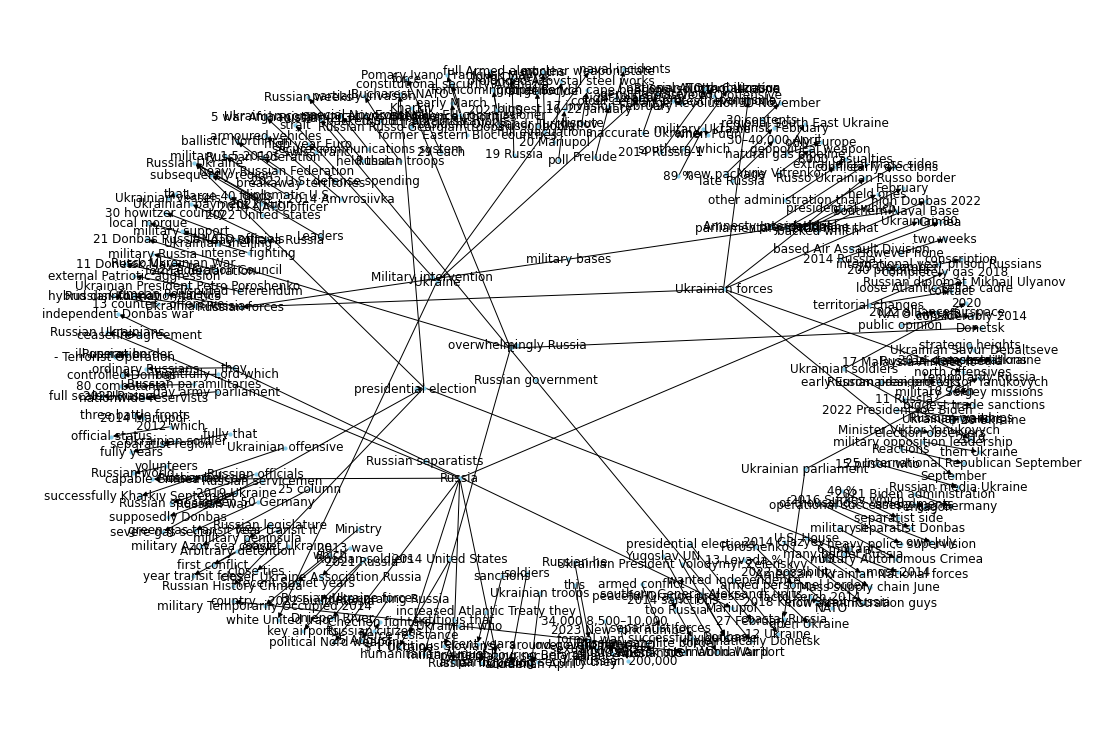

In [91]:
## full
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", edge_attr="relation",
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,10))
nx.draw(G, with_labels=True, node_color='skyblue', cmap=plt.cm.Dark2, node_size=10, 
        pos=nx.spring_layout(G))
plt.show()

In [82]:
## top relations
pd.Series(lst_relations).value_counts()[:10]

said         21
began         9
reported      8
was           7
accused       7
stated        7
described     5
declared      5
announced     5
issued        4
dtype: int64

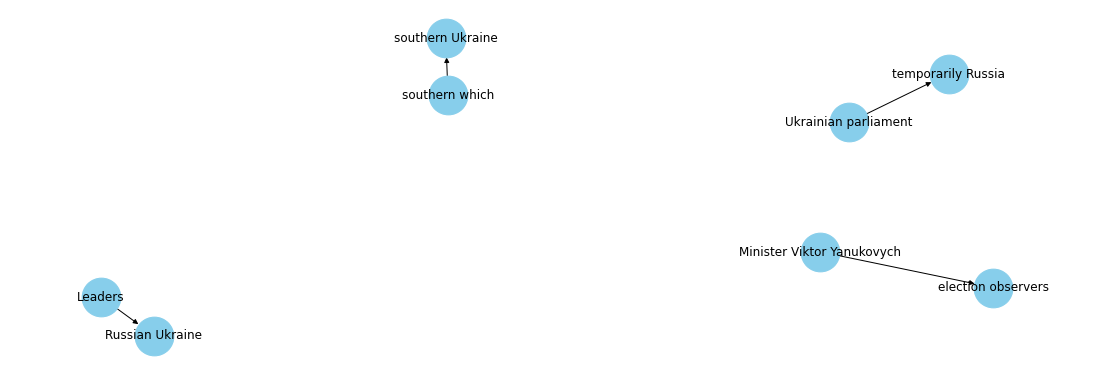

In [101]:
## filter
G = nx.from_pandas_edgelist(dtf[dtf["relation"]=="declared"], 
                            source="entity", target="object", edge_attr="relation",
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,5))
nx.draw(G, with_labels=True, node_color='skyblue', cmap=plt.cm.Dark2, node_size=1500, 
        pos=nx.spring_layout(G, k=0.5))
plt.show()

In [105]:
## setup
pos = nx.spring_layout(G, k=0.2)
for n,p in pos.items():
    G.nodes[n]['pos'] = p
    
## links
edge_x, edge_y = [], []
arrows = []
for n,edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    arrows.append([[x0,y0],[x1,y1]])

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', showlegend=False)

## nodes
node_x, node_y = [], []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', showlegend=False,
                        marker={"showscale":False, "colorscale":'YlGnBu', "reversescale":True, 
                                "size":10, "line_width":2})

## add details
link_text, node_text, node_color, node_size = [], [], [], []
for adjacencies in G.adjacency():
    node_text.append(adjacencies[0])
    for dic in adjacencies[1].values():
        link_text.append(dic["relation"])

node_trace.text = node_text
edge_trace.text = link_text

## layout
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title=topic, showlegend=True, plot_bgcolor='white', 
                  hovermode='closest', width=800, height=800,
                  xaxis={"visible":False}, yaxis={"visible":False})

fig.show()

KeyError: 'relation'

In [44]:
## setup
pos = nx.spring_layout(G, k=0.3)
for n,p in pos.items():
    G.nodes[n]['pos'] = p
    
## links
edge_x, edge_y = [], []
edge_color, edge_size = [], []
arrows = []
for n,edge in enumerate(G.edges()):
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    #edge_color.append(colors[data[cat].iloc[n]])
    #edge_size.append(data[value].iloc[n])
    arrows.append([[x0,y0],[x1,y1]])

edge_trace = go.Scatter(x=edge_x, y=edge_y, mode='lines', showlegend=False)

## nodes
node_x, node_y = [], []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', showlegend=False,
                        marker={"showscale":False, "colorscale":'YlGnBu', "reversescale":True, 
                                "size":10, "line_width":2})

## add node details
node_text, node_color, node_size = [], [], []
for node, adjacencies in enumerate(G.adjacency()):
    ### node text = company name
    node_text.append(adjacencies[0])  
    ### node color = how many links
    node_color.append(len(adjacencies[1]))
    ### node size = how much cash
    cash = sum([i[value] for i in adjacencies[1].values()])
    cash = 20 if cash > 10 else (30 if cash > 20 else np.clip(a=cash, a_min=5, a_max=10))
    node_size.append(cash)

node_trace.text = node_text
node_trace.marker.color = node_color
node_trace.marker.size = node_size

## layout
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(title='search: {}'.format(' + '.join(lst)), showlegend=True, plot_bgcolor='white', 
                  hovermode='closest', width=800, height=800,
                  xaxis={"visible":False}, yaxis={"visible":False})

## add directions
fig.update_layout(annotations=[{"ax":i[0][0], "ay":i[0][1], "axref":'x', "ayref":'y',
                                 "x":i[1][0],  "y":i[1][1],  "xref":'x',  "yref":'y',
                                "showarrow":True, "arrowhead":4, 
                                "arrowcolor":edge_color[n]} 
                              for n,i in enumerate(arrows)])

## add legend
for k,v in colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode="markers", name=k, 
                             marker={"size":7, "color":v, "symbol":'square'}))

fig.show()

NameError: name 'value' is not defined

### 4 - Timeline

In [100]:
 dateparser.parse("the 5th century").strftime('%Y')

AttributeError: 'NoneType' object has no attribute 'strftime'